<a href="https://colab.research.google.com/github/reshma-03/IISc-Projects/blob/main/M6_NB_MiniProject_4_Urban_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Urban Traffic Flow Prediction using Graph Convolution Network - LSTM

## Learning Objectives

At the end of the Mini Project, you will be able to :

* forecast traffic flow using Graph Convolutional Network and LSTM
* understand the graph structured data and implement the forecasting model

## Information

Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is important for

- urban traffic planning,
- traffic management, and
- traffic control.

Traffic forecasting is a challenging issue because of the constraints of the urban road network topological structure and the law of dynamic change with time (spatial dependence and temporal dependence). To capture the spatial and temporal dependence simultaneously, a neural network-based traffic forecasting method called the temporal graph convolutional network (T-GCN) model is very useful. It is a combination of the graph convolutional network (GCN) and gated recurrent unit (GRU).

- Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the T-GCN model is employed to traffic forecasting based on the urban road network. T-GCN model can obtain the spatio-temporal correlation from traffic data and the predictions outperform state-of-art baselines on real-world traffic datasets.

Reference: https://arxiv.org/abs/1811.05320

## Dataset



Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning.

This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). This dataset contains traffic speeds from Mar-1 to Mar-7, 2012 of 207 sensors, recorded every 5 minutes.  There are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes. This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207 for 7 days (12X24X7).

Data Source:
https://github.com/lehaifeng/T-GCN/tree/master/data

## Problem Statement

#### Forecasting urban traffic flow using spatio-temporal data with combined Graph Convolution + LSTM model

## Grading = 10 Points

In [ ]:
#@title Download dataset
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_adj.csv
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_speed.csv
!pip -qq install chardet
!pip -qq install git+https://github.com/VenkateshwaranB/stellargraph.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Import required packages

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
import stellargraph as sg
from stellargraph.layer import GCN
from stellargraph.layer import GCN_LSTM
import networkx as nx

### Data loading and preparation ( 2 points)

In [ ]:
adj_path = "/content/los_adj.csv"
speed_data_path= "/content/los_speed.csv"

In [ ]:
# YOUR CODE HERE
adj_df = pd.read_csv(adj_path, header=None)
speed_df = pd.read_csv(speed_data_path).T
print("Shape of adjacency data : ",adj_df.shape )
print("Shape of Speed data : ",speed_df.shape )
print("Number of sensors : ", speed_df.shape[0])
print("Number of timesteps : ", speed_df.shape[1])

Shape of adjacency data :  (207, 207)
Shape of Speed data :  (207, 2016)
Number of sensors :  207
Number of timesteps :  2016


In [ ]:
speed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.00,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,...,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.75,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,...,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.00,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,...,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.00,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,...,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.50,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,...,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250


In [ ]:
print("Number of null entries in adjacenct data : ",adj_df.isnull().sum().sum())
print("Number of null entries in speed data : ",speed_df.isnull().sum().sum())

Number of null entries in adjacenct data :  0
Number of null entries in speed data :  0


In [ ]:
if (np.array_equal(adj_df, adj_df.T)):
  print("Adjacency matrix is symmetric")
else:
  print("Adjacency matrix is not symmetric")

Adjacency matrix is symmetric


#### Plotting the time series of 10 sensors data

<ipython-input-8-59c227d6dd64>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time = pd.date_range(start="2024-01-01", periods=2016, freq='5T')


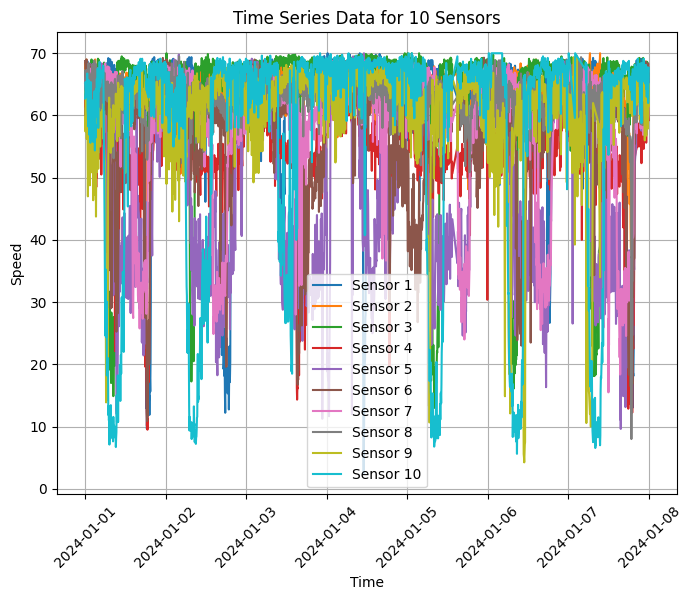

In [ ]:
# YOUR CODE HERE
time = pd.date_range(start="2024-01-01", periods=2016, freq='5T')
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(time, speed_df.iloc[i, :], label=f'Sensor {i+1}')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Time Series Data for 10 Sensors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

#### Create and draw the graph of adjacency of matrix

Hint: [link](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4)

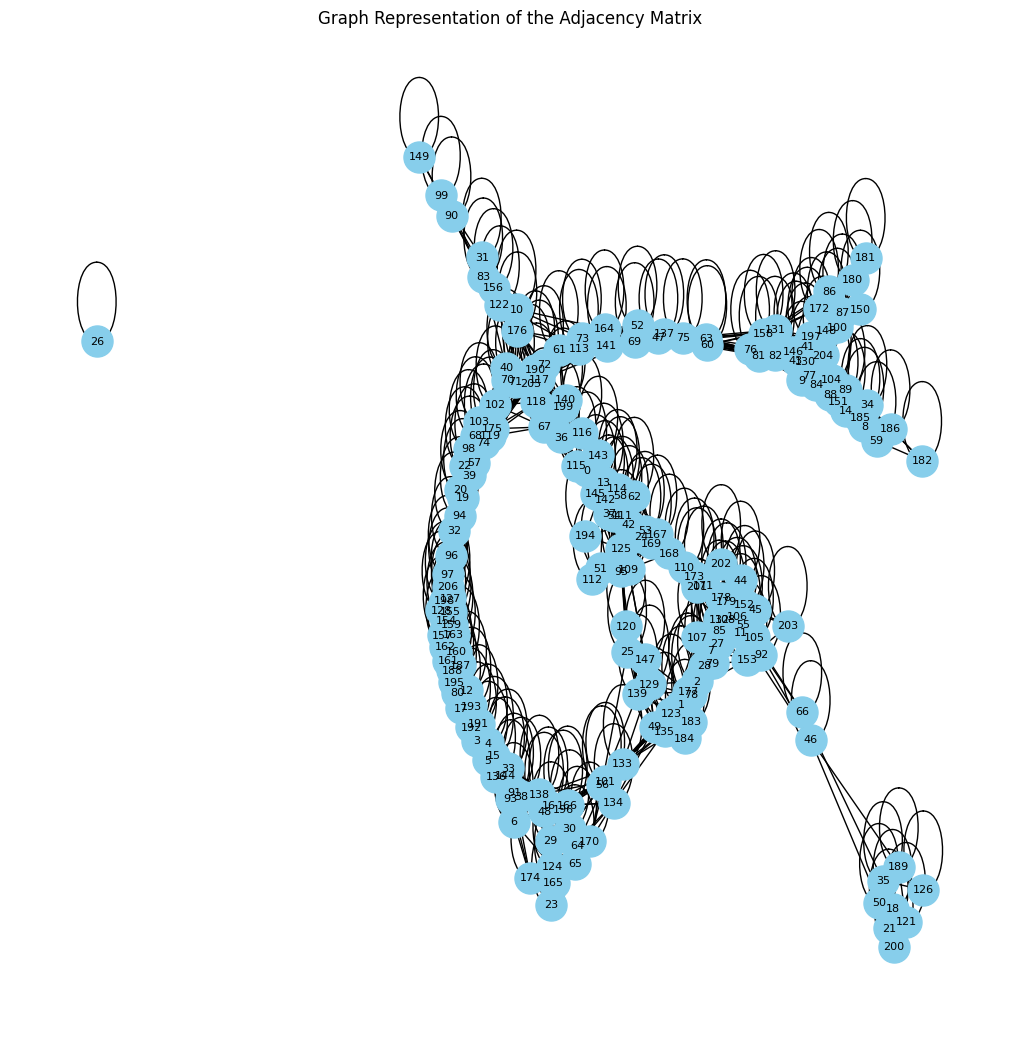

In [ ]:
graph = nx.from_numpy_array(adj_df.values)
plt.figure(figsize=(10, 10))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_color='black')
plt.title('Graph Representation of the Adjacency Matrix')
plt.show()

#### Preprocessing and train test split

In [ ]:
# YOUR CODE HERE
train_size = int(speed_df.shape[1] * 0.8)
train_data = np.array(speed_df.iloc[:, :train_size])
test_data = np.array(speed_df.iloc[:, train_size:])

print("Shape of training dataset",train_data.shape)
print("Shape of test dataset",test_data.shape )

Shape of training dataset (207, 1612)
Shape of test dataset (207, 404)


In [ ]:
max_speed = train_data.max()
min_speed = train_data.min()
train_data_scaled = (train_data - min_speed) / (max_speed - min_speed)
test_data_scaled = (test_data - min_speed) / (max_speed - min_speed)

#### Prepare Time series data


Aim is to use 50 minutes of historical speed observations to predict the speed in future (1 hour ahead)

* Choose windows of 10 historical observations i.e. 5 * 10 = 50 minutes (`seq_len`) for each segment as the input and use it to predict the speed after 5 * 12 = 60 minutes (target) using the sliding window approach.

**Note:**
The below parameters
-  `seq_len` is the size of the past window of information.
- `pre_len` is future prediction ( 1 hour in future = 12 * 5 minutes)



Steps:

* Prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a **sequence of past observations as input to an output observation**, so the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

* Choose to use 50 minutes of historical speed observations to predict the speed in future (eg. 1 hour ahead). First reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later as the prediction label. This can be performed using a sliding window approach:

    - Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict.

    - Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict.

    - Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

  *Note: The above steps are done for each sensor.*

Define a function below to return the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

Each **training observation** is 10 historical speeds **(seq_len).**

Each **training prediction** is the speed 60 minutes later **(pre_len).**

In [ ]:
seq_len = 10
pre_len = 12
# YOUR CODE HERE
def sliding_window(data, seq_len, pre_len):
  n_samples = data.shape[1]-seq_len-pre_len+1
  n_sensors = data.shape[0]
  X, y = [], []
  for i in range(n_samples):
    temp = data[:, i : i + seq_len + pre_len]
    X.append(temp[:, :seq_len])
    y.append(temp[:, -1])
  return np.array(X), np.array(y)

X_train, y_train = sliding_window(train_data_scaled, seq_len, pre_len)
X_test, y_test = sliding_window(test_data_scaled, seq_len, pre_len)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1591, 207, 10), (1591, 207), (383, 207, 10), (383, 207))

### Build and Train the LSTM model and plot the loss results (3 points)

In [ ]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], seq_len)),
    Dropout(0.3),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(1, activation='tanh')),
])
model_lstm.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 207, 128)          71168     
                                                                 
 dropout (Dropout)           (None, 207, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 207, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 207, 128)          0         
                                                                 
 time_distributed (TimeDist  (None, 207, 1)            129       
 ributed)                                                        
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202881 (792.50 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
hist = model_lstm.fit(x = X_train,y= y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/30
50/50 [==============================] - 25s 445ms/step - loss: 0.0490 - mae: 0.1413 - val_loss: 0.0410 - val_mae: 0.1353
Epoch 2/30
50/50 [==============================] - 21s 426ms/step - loss: 0.0323 - mae: 0.1210 - val_loss: 0.0374 - val_mae: 0.1420
Epoch 3/30
50/50 [==============================] - 21s 423ms/step - loss: 0.0289 - mae: 0.1157 - val_loss: 0.0323 - val_mae: 0.1260
Epoch 4/30
50/50 [==============================] - 21s 417ms/step - loss: 0.0234 - mae: 0.1037 - val_loss: 0.0260 - val_mae: 0.1001
Epoch 5/30
50/50 [==============================] - 21s 426ms/step - loss: 0.0193 - mae: 0.0884 - val_loss: 0.0232 - val_mae: 0.0949
Epoch 6/30
50/50 [==============================] - 21s 424ms/step - loss: 0.0184 - mae: 0.0857 - val_loss: 0.0226 - val_mae: 0.0995
Epoch 7/30
50/50 [==============================] - 21s 427ms/step - loss: 0.0182 - mae: 0.0849 - val_loss: 0.0245 - val_mae: 0.0935
Epoch 8/30
50/50 [==============================] - 21s 420ms/step - 

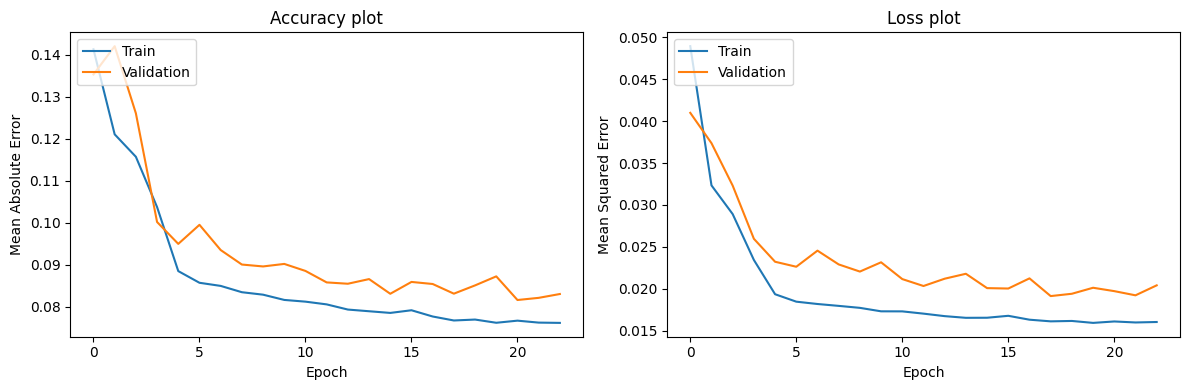

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Accuracy plot')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss plot')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
y_test_pred = model_lstm.predict(X_test)
print(y_test_pred.shape)
y_test_pred_reshaped = y_test_pred.reshape(y_test_pred.shape[:-1])
y_test_pred_rescaled = y_test_pred_reshaped * (max_speed - min_speed) + min_speed
y_test_rescaled = y_test * (max_speed - min_speed) + min_speed

mae_sensors, mape_sensors, mse_sensors = [], [], []
for i in range(y_test_pred.shape[1]):
  mae_sensors.append(mean_absolute_error(y_test_rescaled[:, i], y_test_pred_rescaled[:, i]))
  mse_sensors.append(mean_squared_error(y_test_rescaled[:, i], y_test_pred_rescaled[:, i]))
  mape_sensors.append(mean_absolute_percentage_error(y_test_rescaled[:, i], y_test_pred_rescaled[:, i]))

12/12 [==============================] - 2s 130ms/step
(383, 207, 1)


In [ ]:
mean_absolute_error(y_test_rescaled, y_test_pred_rescaled), mean_absolute_percentage_error(y_test_rescaled, y_test_pred_rescaled), mean_squared_error(y_test_rescaled, y_test_pred_rescaled)


(5.725598668817983, 0.1842947048185772, 97.09234989667185)

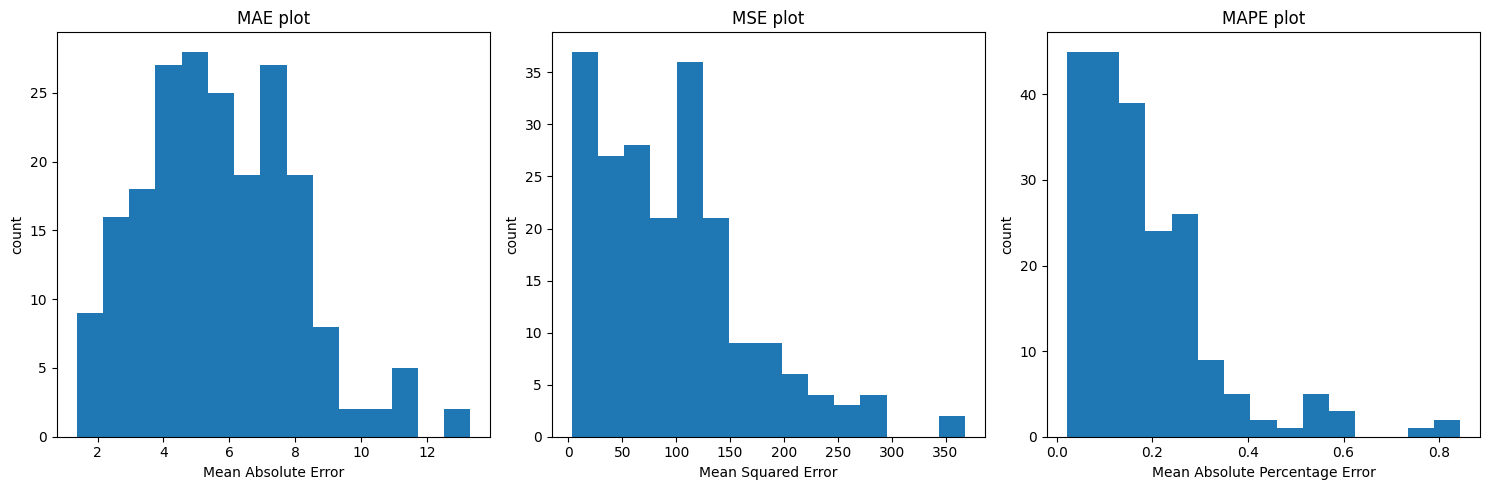

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('MAE plot')
plt.ylabel('count')
plt.xlabel('Mean Absolute Error')
plt.hist(mae_sensors, bins=15)
plt.subplot(1, 3, 2)
plt.title('MSE plot')
plt.ylabel('count')
plt.xlabel('Mean Squared Error')
plt.hist(mse_sensors, bins=15)
plt.subplot(1, 3, 3)
plt.title('MAPE plot')
plt.ylabel('count')
plt.xlabel('Mean Absolute Percentage Error')
plt.hist(mape_sensors, bins=15)
plt.tight_layout()

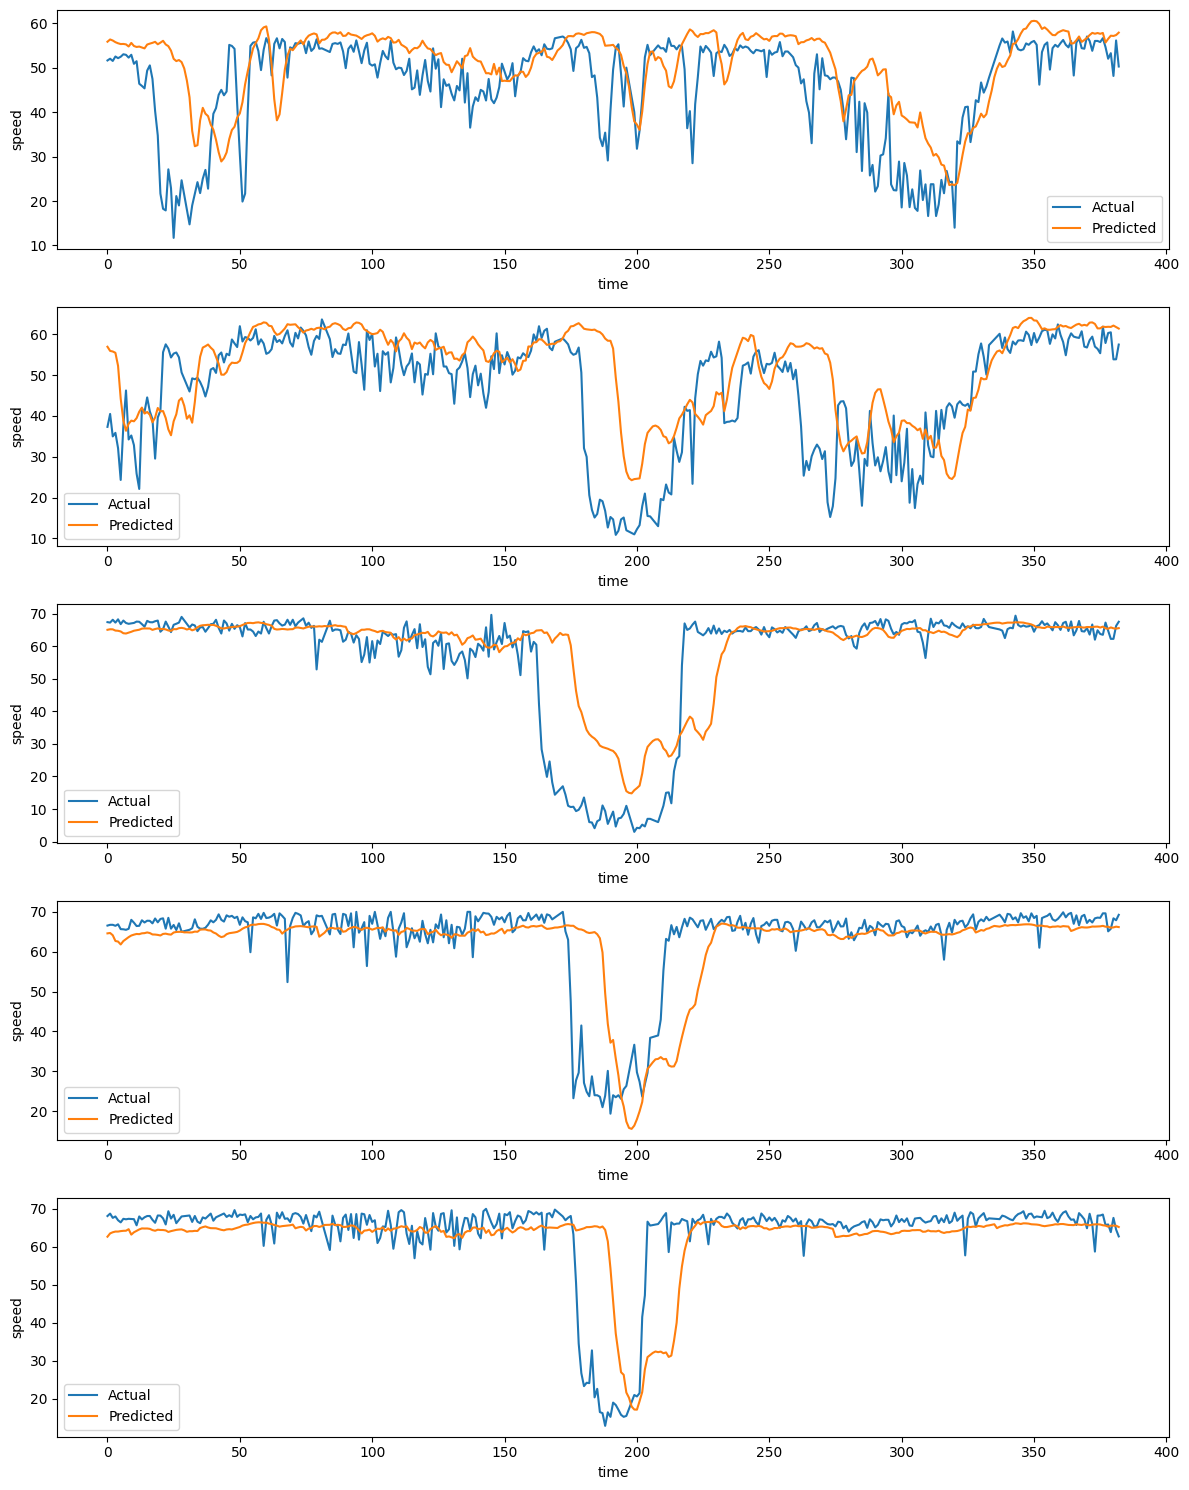

In [ ]:
plt.figure(figsize=(12, 15))
for i in range(5):
  plt.subplot(5, 1, i+1)
  plt.plot(y_test_rescaled[:, 75+i], label='Actual')
  plt.plot(y_test_pred_rescaled[:, 75+i], label='Predicted')
  plt.legend()
  plt.xlabel("time")
  plt.ylabel("speed")
plt.tight_layout()

### StellarGraph Graph Convolution and LSTM model ( 3 points)

In order to use the model, we need:

* An **N by N** adjacency matrix, which describes the distance relationship between the N sensors,

* An **N by T** feature matrix, which describes the ($f_1, .., f_T$) speed records over T timesteps for the N sensors.

Arguments of GCN_LSTM:
  - seq_len: No. of LSTM cells

  - adj: unweighted/weighted adjacency matrix

  - gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.

  - lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.

  - gc_activations (list of str or func): Activations applied to each layer's output.

  - lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.

In [ ]:
# Implement GCN-LSTM
# YOUR CODE HERE
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=adj_df,
    gc_layer_sizes=[20, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[250, 250],
    lstm_activations=["tanh", "tanh"],
)
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])
model.summary()

<ipython-input-20-66792118e2ed>:3: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm = GCN_LSTM(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 207, 10)]         0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 207, 10, 1)        0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 207, 10)           0         
                                                                 
 fixed_adjacency_graph_conv  (None, 207, 20)           43256     
 olution (FixedAdjacencyGra                                      
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_conv  (None, 207, 10)           43256     
 olution_1 (FixedAdjacencyG                                  

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test),
)

Epoch 1/100
50/50 [==============================] - 11s 165ms/step - loss: 0.1421 - mse: 0.0474 - val_loss: 0.1112 - val_mse: 0.0434
Epoch 2/100
50/50 [==============================] - 7s 143ms/step - loss: 0.0987 - mse: 0.0306 - val_loss: 0.1073 - val_mse: 0.0416
Epoch 3/100
50/50 [==============================] - 7s 143ms/step - loss: 0.0924 - mse: 0.0287 - val_loss: 0.1057 - val_mse: 0.0409
Epoch 4/100
50/50 [==============================] - 7s 143ms/step - loss: 0.0892 - mse: 0.0279 - val_loss: 0.1047 - val_mse: 0.0406
Epoch 5/100
50/50 [==============================] - 7s 143ms/step - loss: 0.0876 - mse: 0.0276 - val_loss: 0.1044 - val_mse: 0.0402
Epoch 6/100
50/50 [==============================] - 7s 143ms/step - loss: 0.0857 - mse: 0.0268 - val_loss: 0.1021 - val_mse: 0.0370
Epoch 7/100
50/50 [==============================] - 7s 143ms/step - loss: 0.0838 - mse: 0.0257 - val_loss: 0.1019 - val_mse: 0.0368
Epoch 8/100
50/50 [==============================] - 7s 143ms/step -

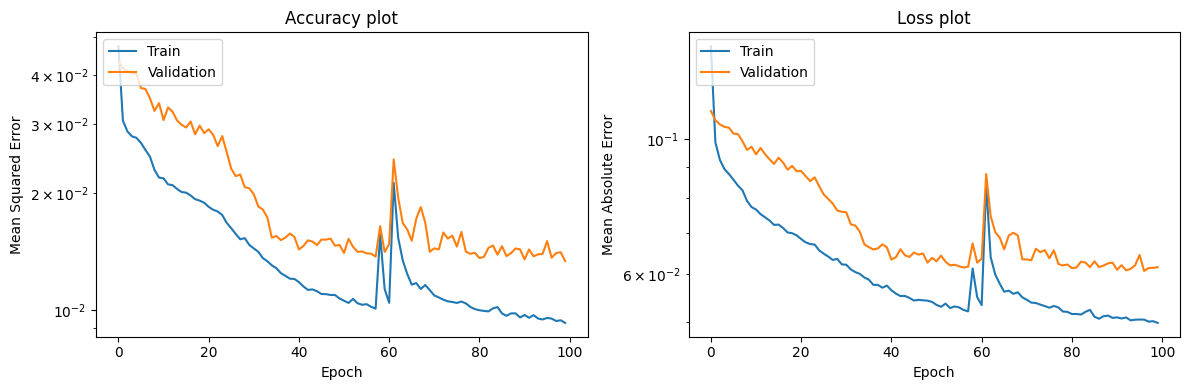

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogy(history.history['mse'])
plt.semilogy(history.history['val_mse'])
plt.title('Accuracy plot')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Loss plot')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()

In [ ]:
y_test_pred = model.predict(X_test)

12/12 [==============================] - 1s 40ms/step


#### Rescale values
Rescale the predicted values to the original value range of the timeseries.

In [ ]:
# YOUR CODE HERE
y_test_pred_rescaled = y_test_pred * (max_speed - min_speed) + min_speed
y_test_rescaled = y_test * (max_speed - min_speed) + min_speed

### Plot the predictions and Loss of each sensor ( 2 points)

* Select any one sensor's prediction and plot the graph.

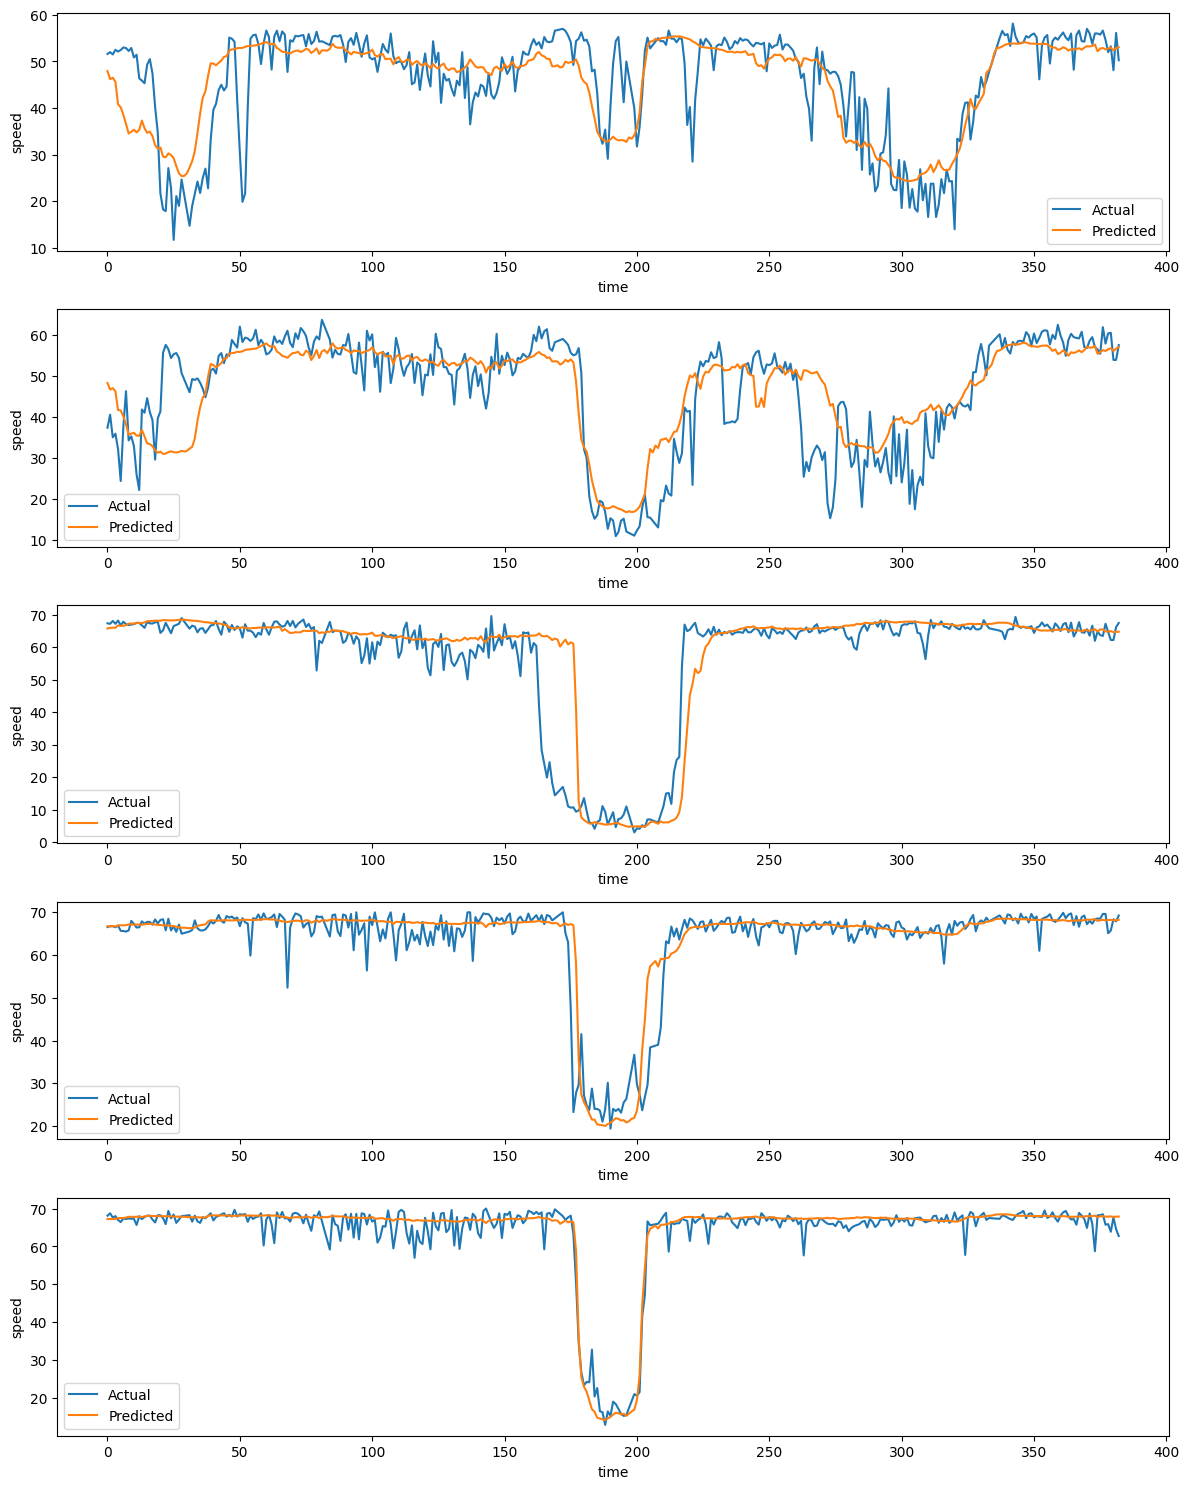

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(12, 15))
for i in range(5):
  plt.subplot(5, 1, i+1)
  plt.plot(y_test_rescaled[:, 75+i], label='Actual')
  plt.plot(y_test_pred_rescaled[:, 75+i], label='Predicted')
  plt.legend()
  plt.xlabel("time")
  plt.ylabel("speed")
plt.tight_layout()

#### Plot error (MAE and MSE) for all the sensors

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae_sensors, mape_sensors, mse_sensors = [], [], []
for i in range(y_test_pred.shape[1]):
  mae_sensors.append(mean_absolute_error(y_test_rescaled[:, i], y_test_pred_rescaled[:, i]))
  mse_sensors.append(mean_squared_error(y_test_rescaled[:, i], y_test_pred_rescaled[:, i]))
  mape_sensors.append(mean_absolute_percentage_error(y_test_rescaled[:, i], y_test_pred_rescaled[:, i]))

In [ ]:
mean_absolute_error(y_test_rescaled, y_test_pred_rescaled), mean_absolute_percentage_error(y_test_rescaled, y_test_pred_rescaled), mean_squared_error(y_test_rescaled, y_test_pred_rescaled)

(4.247776217513673, 0.13107882616120473, 63.66968324029559)

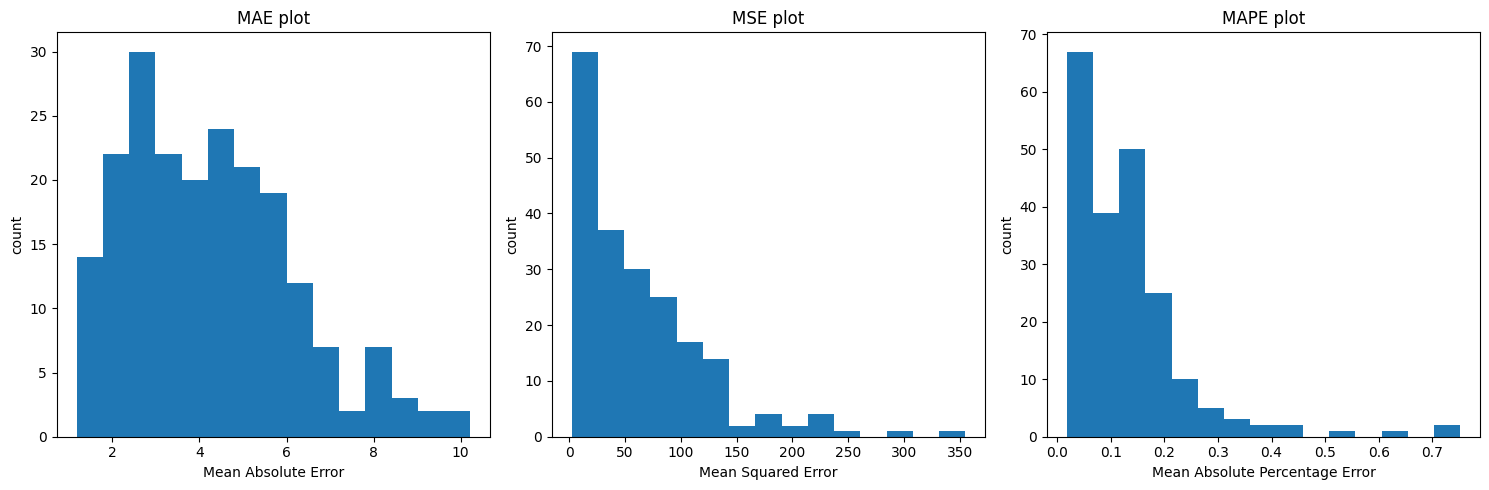

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('MAE plot')
plt.ylabel('count')
plt.xlabel('Mean Absolute Error')
plt.hist(mae_sensors, bins=15)
plt.subplot(1, 3, 2)
plt.title('MSE plot')
plt.ylabel('count')
plt.xlabel('Mean Squared Error')
plt.hist(mse_sensors, bins=15)
plt.subplot(1, 3, 3)
plt.title('MAPE plot')
plt.ylabel('count')
plt.xlabel('Mean Absolute Percentage Error')
plt.hist(mape_sensors, bins=15)
plt.tight_layout()

#### Report Analysis

  * Discuss: Why is this called a spatio-temporal problem?

  * Discuss: In what way is GCN-LSTM more useful for the traffic prediction task than LSTM?